In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from hydra import initialize, compose
from hydra.utils import get_class, instantiate
from omegaconf import OmegaConf

In [2]:
with initialize(version_base=None, config_path="config/conf"):
    cfg = compose(config_name="config.yaml", overrides=["dataset.batch_size=64", "early_stopper=null", "+experiment=E25"])
# print(OmegaConf.to_yaml(cfg))

In [3]:
dm = instantiate(cfg.dataset)
dm.setup()
train_loader = dm.train_dataloader()
train_set = train_loader.dataset

[nltk_data] Downloading package wordnet to /home/danis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/danis/anaconda3/envs/bottleneck/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
100%|██████████| 2700/2700 [00:00<00:00, 9057.84it/s]


Len of vocab:  54
Max len of caption:  16
Index for <pad>: [0]


In [4]:
# model = instantiate(cfg.model)

checkpoint_path = "/home/danis/Projects/AlphaCaption/AutoConceptBottleneck/autoconcept/outputs/2023-04-28/08-56-39/lightning_logs/version_0/checkpoints/epoch008-val_loss1.40191.ckpt"
target_class = get_class(cfg.model._target_)
main = instantiate(cfg.model.main)
model = target_class.load_from_checkpoint(
    checkpoint_path, main=main).cuda()

/home/danis/anaconda3/envs/bottleneck/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'criterion_task' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion_task'])`.
  rank_zero_warn(
/home/danis/anaconda3/envs/bottleneck/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'criterion_tie' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion_tie'])`.
  rank_zero_warn(


In [5]:
batch = next(iter(train_loader))

In [6]:
def inference_model(model, batch, sample_idx):
    sample = dict(image=None, indices=None, target=None, report=None, img_path=None)
    for k, v in batch.items():
        if k in sample:
            sample[k] = v[sample_idx]
            if isinstance(sample[k], torch.Tensor):
                sample[k] = sample[k].unsqueeze(dim=0)
    model.eval()
    output = model(sample['image'].cuda(), sample['indices'].cuda(), iteration=None)
    
    for k, v in output.items():
        if isinstance(output[k], torch.Tensor):
            output[k] = output[k].cpu().detach().squeeze(dim=0).numpy()
    
    for k, v in sample.items():
        if isinstance(sample[k], torch.Tensor):
            sample[k] = sample[k].cpu().detach().squeeze(dim=0).numpy()

    num_embeddings = model.main.concept_extractor.queries_w.num_embeddings
    out_features = model.main.concept_extractor.out_features
    dummy_embedding = num_embeddings - out_features
    
    x_ticks = sample['report'].split()
    x_ticks += ["<pad>"] * (output["scores_aux"].shape[1] - len(x_ticks))
    x_ticks[-1] = "<dummy>"

    y_ticks = [f"c{i}" for i in range(1, out_features + 1)] + ["dummy"] * dummy_embedding

    ax = sns.heatmap(output["scores_aux"], linewidth=0.5)
    ax.set_xticklabels(x_ticks)
    ax.set_yticklabels(y_ticks)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=45)
    plt.show()
    
    return output, sample

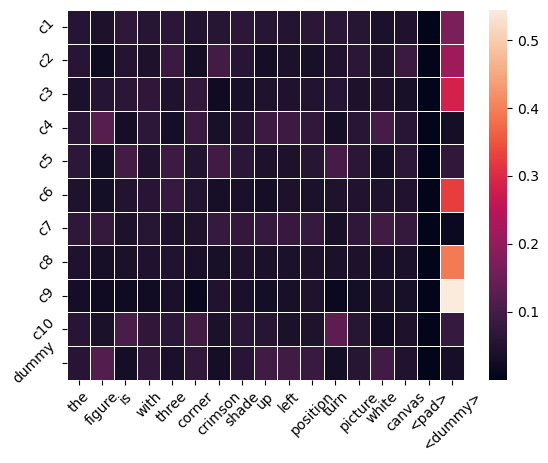

In [7]:
output, sample = inference_model(model, batch, 0)

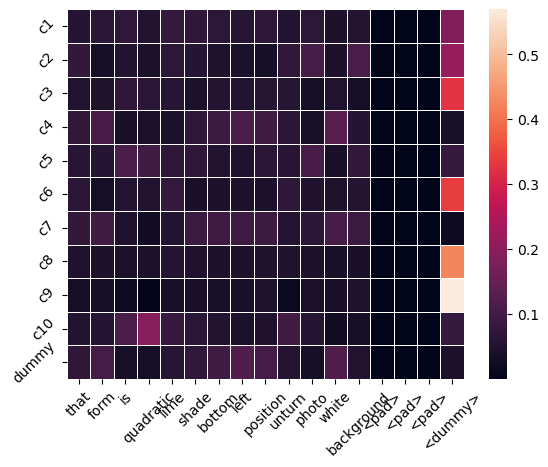

In [8]:
output, sample = inference_model(model, batch, 1)

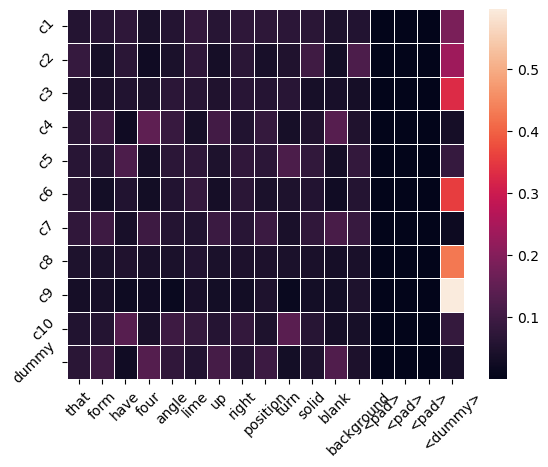

In [9]:
output, sample = inference_model(model, batch, 2)

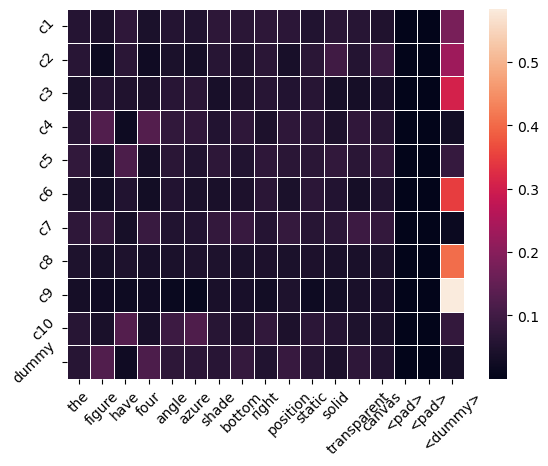

In [10]:
output, sample = inference_model(model, batch, 3)

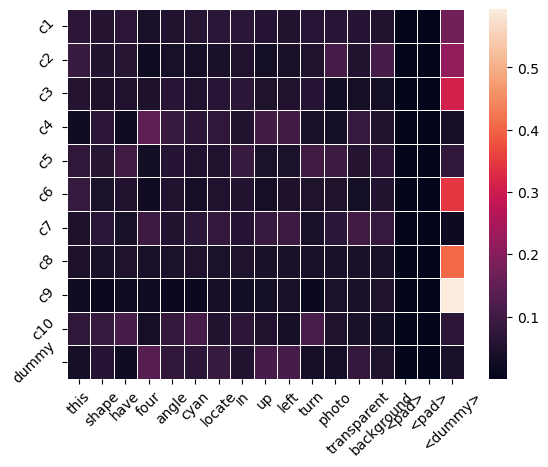

In [11]:
output, sample = inference_model(model, batch, 4)